# Hands on : introduction to BDT on HEP dataset

## Standard Imports

In [1]:
#COLAB=False #if running on local anaconda installation https://docs.anaconda.com/anaconda/install/
COLAB=False #if running on https://colab.research.google.com/notebooks/welcome.ipynb

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython import display USEFUL ???
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', 100) # to see more columns of df.head()
np.random.seed(31415) # set the np random seed for the reproducibility

In [3]:
# Fix environment if necessary
if COLAB:
    !pip install eli5 # permutation importance package, now obsolete but good enough
    pass
else:    
    # install xgboost and lighgbm, two popular Boosted Decision Tree packages
    # normally it is just a matter of a few pip install but there might be some glitches
    # note : I have better experience with pip install than conda install. 
    # the following need to be done only once. To be commented out later
    #!pip install xgboost # might need to run !pip install cmake first   
    #!pip install lightgbm # might need to run before brew install libopm on a mac
    #!pip install eli5
    pass

import xgboost
print (xgboost.__version__) # Tested with 1.0.2, version above 1 is recommended. Colab has 0.9.0, good enough 
import lightgbm
print (lightgbm.__version__) # Tested with 2.3.1
import eli5
print (eli5.__version__) # Tested with 0.10.1



1.3.1
3.1.1
0.10.1


In [4]:
if COLAB:
    #### Reading files from Google Drive
    # one need a google account to be identified
    # select a google account, then cut and paste the long password in the pop up field
    !pip install PyDrive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

# Load events

In [5]:
if COLAB:

    #attach dataset from google drive 
    download = drive.CreateFile({'id': '1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4'})
    download.GetContentFile("dataWW_d1_600k.csv.gz")


    datapath=""


    !ls -lrt
else :
    # make sure the file is available locally. 
    #Should be downloaded from https://drive.google.com/open?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
    !ls -lrt # what is in the local directory
    datapath="/Users/rousseau/Google\ Drive/GD_openData/dataWW_ATLAS_openData13TeV_filtered/"

    !ls -lrt {datapath} # what is in the data directory
    datapath=os.path.abspath(datapath).replace("\ ", " ")  # try to normalise the path (annoyance with the space)
    print ("Will take data from : ",datapath)

filename=os.path.join(datapath,"dataWW_d1_600k.csv.gz")
#load data
# data was created from ATLAS Open Data see doc
# http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html
dfall = pd.read_csv(filename) 

#shuffle the events, already done but just to be safe
dfall = dfall.sample(frac=1).reset_index(drop=True)
print ("File loaded with ",dfall.shape[0], " events ")



total 352
-rw-r--r--@ 1 rousseau  staff   40958 12 jan 11:22 Copy_of_Welcome_To_Colaboratory.ipynb
-rw-r--r--+ 1 rousseau  staff    3881 13 jan 15:27 requirements.txt
-rw-------@ 1 rousseau  staff  132527 14 jan 13:50 HEPML_HandsOn_BDT.ipynb
total 70344
-rwxr-xr-x+ 1 rousseau  staff  35905611 13 mai  2020 dataWW_d1_600k.csv.gz
Will take data from :  /Users/rousseau/Google Drive/GD_openData/dataWW_ATLAS_openData13TeV_filtered
File loaded with  600000  events 


At this point, it should tell you "File Loaded with XXX events". If not, it could not access the datafile, no point going further !

# Examine dataset

In [6]:
#dump list of feature
dfall.columns

Index(['eventNumber', 'label', 'met_et', 'met_phi', 'lep_n', 'lep_pt_0',
       'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1',
       'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1', 'lep_type_0',
       'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1', 'jet_eta_0', 'jet_eta_1',
       'jet_phi_0', 'jet_phi_1', 'jet_E_0', 'jet_E_1', 'mcWeight', 'runNumber',
       'channelNumber'],
      dtype='object')

In [7]:
#examine first few events
dfall.head()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000002,284500,345323
1,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.000288,284500,363492
2,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
3,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
4,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000002,284500,345323


In [8]:
#examine feature distribution
dfall.describe()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000218,284500.0,351379.666667
std,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.000736,0.0,8564.720183
min,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.045557,284500.0,345323.000000
25%,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000002,284500.0,345323.000000
50%,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000029,284500.0,345324.000000
75%,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000197,284500.0,363492.000000
max,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.052420,284500.0,363492.000000


In [9]:
label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("total label weights",label_weights)


label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print ("total class number of events",label_nevents)









total label weights (124.6622944642, 6.2000533976)
total class number of events (200000, 400000)


## Event selection

In [10]:
print (dfall.shape)
fulldata=dfall[dfall.lep_n==2] # only keep events with exactly two leptons 
print (fulldata.shape)



(600000, 29)
(596571, 29)


In [11]:
#hide label and weights in separate vectors
#they are not real features

#WARNING : there should be no selection nor shuffling later on !
target = fulldata["label"]
del fulldata["label"]

#hide weight in separate vector
weights = fulldata["mcWeight"]
del fulldata["mcWeight"]
fulldata.shape

(596571, 27)


# DO NOT MODIFY ANYTHING ABOVE
... and always rerun from this cell whenever you change something below

In [12]:
# for simplicity of the exercise only keep some features
# this is actually making a copy from fulldata
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])
#data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1']
print (data.shape)
data.head()




(596571, 6)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.609,0.42452,48.295,15.214,-2.316400,-1.39410
1,196.560,1.31140,69.459,21.081,0.023132,-0.67855
2,45.653,-2.76860,45.927,22.822,1.901700,-0.11248
3,49.415,-0.57805,45.929,14.263,2.254700,-2.54810
4,71.988,-2.60390,62.029,21.453,0.236200,1.40820


## Examine the weights

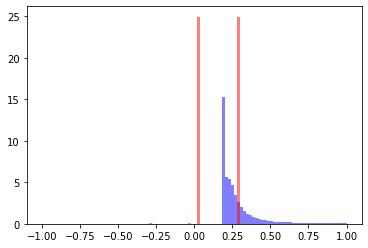

In [13]:
plt.figure()
bins=np.linspace(-1,1,101)
plt.hist(weights[target==0]*1000,bins=bins,color='b',alpha=0.5,density=True)
plt.hist(weights[target==1]*10000,bins=bins,color='r',alpha=0.5,density=True)
plt.show()

In [14]:
label_n_weights=np.zeros(2)
label_sum_weights=np.zeros(2)
label_mean_weights=np.zeros(2)
label_std_weights=np.zeros(2)
label_neff_fraction=np.zeros(2)

for i in range(2):
  label_n_weights[i]=weights[target==i].size
  label_mean_weights[i]=weights[target==i].mean()
  label_std_weights[i]=weights[target==i].std()
  label_sum_weights[i]=weights[target==i].sum()
  label_neff_fraction[i]=1/(1+(label_std_weights[i]/label_mean_weights[i])**2)

print ("Weights quantities for background (target==0) and signal (target==1)")
print ("Weights sum",label_sum_weights)
print ("N events",label_n_weights)
print ("Weights mean",label_mean_weights)
print ("Weights std",label_std_weights)
print ("Weights Neff fraction",label_neff_fraction)

Weights quantities for background (target==0) and signal (target==1)
Weights sum [124.0090875   6.1665821]
N events [198843. 397728.]
Weights mean [6.23653272e-04 1.55045209e-05]
Weights std [1.17462510e-03 1.36312711e-05]
Weights Neff fraction [0.2199051  0.56402909]


# Feature engineering
To be switched on in a second iteration

In [15]:
if False: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)
    #data["lep_deltaphi"]=data.lep_phi_1-data.lep_phi_0


    print (data.shape)
    display(data.head())
   

    



<Figure size 432x288 with 0 Axes>

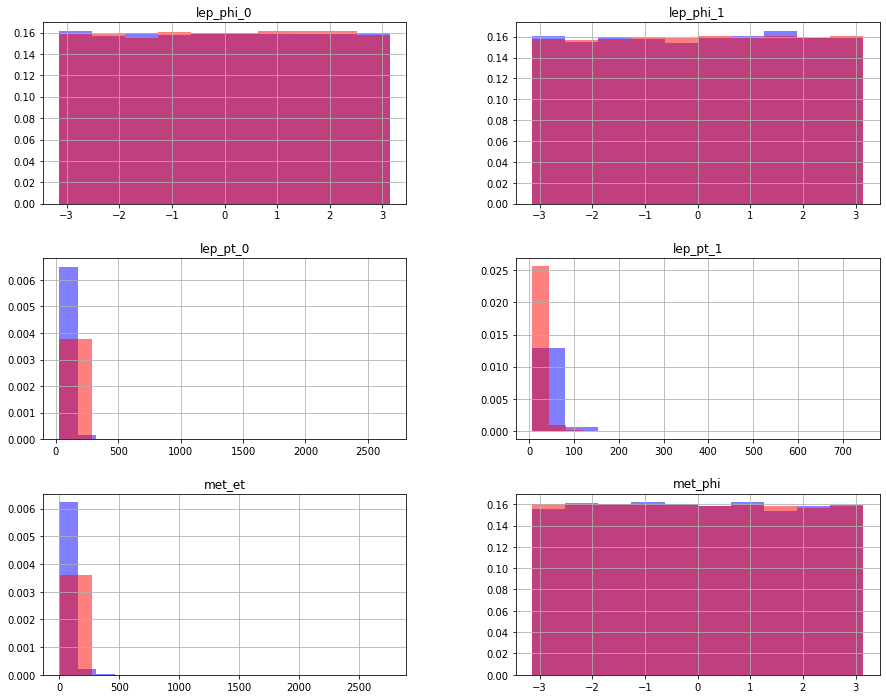

In [16]:


plt.figure()

#_, ax = plt.subplots()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True)
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax)




plt.show()


## Split dataset and transform of the features

In [17]:
np.random.seed(31415) # set the random seed (used for the train/test splitting)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)





#scale to mean 0 and variance 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 
    
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())


    

(447428, 6)
(447428,)
(447428,)
(149143, 6)
(149143,)
(149143,)
class_weights_train: (92.9604778634, 4.630810828000002)
Test : total weight sig 6.1430850784
Test : total weight bkg 124.1944385552
Train : total weight sig 92.96047786339997
Train : total weight bkg 92.9604778634


# Testing BDT

## Load significance function

In [18]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov significance arXiv:1007.1727 eq. 97
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)


## XGBoost

In [19]:
np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
xgb = XGBClassifier(use_label_encoder=False) ##DR is hist the default in XGB 1.3.1 ? tree_method="gpu_hist",
#xgb = XGBClassifier(tree_method="hist",max_depth=12) # HPO, check on the web for other parameters
# not a bad idea to check for bugs without hist


starting_time = time.time( )
xgb.fit(X_train, y_train.values, sample_weight=weights_train.values)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

AttributeError: dlsym(0x7fb3cdf6d840, XGDMatrixSetDenseInfo): symbol not found

In [ ]:
#gridSearchCV for advanced HPO, check on the web for other parameters

if False:
    from sklearn.model_selection import GridSearchCV

    #param_list = {'max_depth': [3, 6, 7], 'subsample': [0.7, 1],
    #                    'learning_rate': [0.05, 0.3], 'n_estimators': [10, 50, 200]}
    # all possible combinations of parameters will be used, can take a few minutes
    #param_list_XGB = {'max_depth': [6,10], 'subsample': [0.7,1],
    #                    'learning_rate': [0.05, 0.3], 'max_leaves': [50, 200]}
    param_list_XGB = {'max_depth': [2,5],"n_estimators" : [50,100]}



    gsearch1 = GridSearchCV(estimator = XGBClassifier(tree_method="hist"), 
                        param_grid = param_list_XGB, 
                        scoring='roc_auc',n_jobs=-1,iid=False, cv=2)
    gsearch1.fit(X_train,y_train, weights_train)
    print (gsearch1.best_params_)
    print (gsearch1.best_score_)

    y_pred_gs = gsearch1.predict_proba(X_test)[:,1]
    roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test)

## LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier()
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
Z = significance_gbm
print("Z:",Z)
# To save model
gbm.booster_.save_model("LightGBM.model")




In [ ]:
#gridSearchCV for advanced HPO
if False:
    from sklearn.model_selection import GridSearchCV
    #param_list_GBM = {'max_depth': [3, 6, 7],
    #                     'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'n_estimators': [10, 20, 40, 50, 200]}
    param_list_GBM = {'max_depth': [6,10], 
                        'learning_rate': [0.05, 0.3], 'n_estimators': [10, 200]}


    gsearch1 = GridSearchCV(estimator = XGBClassifier(), 
    param_grid = param_list_GBM, scoring='roc_auc',n_jobs=4,iid=False, cv=2)
    gsearch1.fit(X_train,y_train, weights_train)
    print (gsearch1.best_params_)
    print (gsearch1.best_score_)

    y_pred_gs = gsearch1.predict_proba(X_test)[:,1]
    roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test)

In [ ]:
print('Best significance found are:')
print('LightGBM: ', significance_gbm)
print('XGBoost : ', significance_xgb)
print('Best auc train found are:')
print('LightGBM: ', roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))
print('XGBoost: ', roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,)) 

## Some nice plots 

## load score plotting function

In [ ]:
# some utilities
from math import sqrt
from math import log

# Plot score for signal and background, comparing training and testing
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30, xlabel="", ylabel="Arbitrary units", title="", weights_train=np.array([]), weights_test=np.array([])):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=True, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=True, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')




In [ ]:

compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, xlabel="XGboost score", title="XGboost")#, weights_train=weights_train.values, weights_test=weights_test.values)
plt.savefig("Score_BDT_XGBoost_Hist.pdf")
plt.show()
compare_train_test(y_pred_train_gbm, y_train, y_pred_gbm, y_test, xlabel="LightGBM score", title="LightGBM")#, weights_train=weights_train.values, weights_test=weights_test.values)
plt.savefig("Score_BDT_LightGBM.pdf")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
lw = 2

fpr_gbm,tpr_gbm,_ = roc_curve(y_true=y_test, y_score=y_pred_gbm,)#,sample_weight=weights_test.values)
fpr_xgb,tpr_xgb,_ = roc_curve(y_true=y_test, y_score=y_pred_xgb,)#,sample_weight=weights_test.values)
plt.plot(fpr_gbm, tpr_gbm, color='darkorange',lw=lw, label='LightGBM (AUC  = {})'.format(np.round(auc_test_gbm,decimals=2)))
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#import os
#new_dir = "Plots/Comparing" 
#if not os.path.isdir(new_dir):
#    os.mkdir(new_dir)
plt.savefig("ROC_comparing.pdf")
plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_gbm, label='LightGBM (Z = {})'.format(np.round(significance_gbm,decimals=2)))
plt.plot(np.linspace(0,1,num=50),vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb,decimals=2)))

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_comparing.pdf")
plt.show()

In [ ]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
#plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
plt.show()
plt.bar(data.columns.values, gbm.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
#plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
plt.show()


# Permutation importance

In [ ]:
#TODO replace by Aishik's stuff
#a bit slow
#if COLAB:
if True:  
    import eli5
    from eli5.sklearn import PermutationImportance
    file = open('html_original.html', 'w')
    file.write(HTML('<h1>Permutation importances XGBoost</h1>').data)
    perm_xgb = PermutationImportance(xgb, random_state=1).fit(X_test, y_test)#, sample_weight=weights_test.values)
    html_xgb = eli5.show_weights(perm_xgb, feature_names = data.columns.values).data
    #with open('html_xgb.html', 'w') as f:
    #    f.write(HTML('<h1>Permutation importances XGBoost Hist</h1>').data)
    #    f.write(html_xgb)
    file.write(html_xgb)
    perm_gbm = PermutationImportance(gbm, random_state=1).fit(X_test, y_test)#, sample_weight=weights_test.values)
    html_gbm = eli5.show_weights(perm_gbm, feature_names = data.columns.values).data
    #with open('html_gbm.html', 'w') as f:
    #    f.write(HTML('<h1>Permutation importances LightGBM</h1>').data)
    #    f.write(html_gbm)
    file.write(HTML('<h1>Permutation importances LightGBM</h1>').data)
    file.write(html_gbm)
    print ("Permutation importances XGBoost")
    display(eli5.show_weights(perm_xgb, feature_names = data.columns.values))
    print ("Permutation importances LightGBM")
    display(eli5.show_weights(perm_gbm, feature_names = data.columns.values))
    file.close()